In [1]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

/u/ywagh/.local/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

In [3]:
slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

In [4]:
ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]   #working only with primary fields

In [5]:
#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[6]))

plot_filename = os.path.basename(filelist[6])
#******************************************************************************

In [6]:
event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'

event_time

<Time object: scale='utc' format='iso' value=2019-09-30 13:35:41.243>

In [7]:
event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 180 * u.second
exposure_time_day = exposure_time.to_value(u.day)

cadence = 60         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
min_start.format = 'jd'
max_end.format = 'jd'

num_visits = 2
num_filters = 2

k = int(np.floor((max_end - min_start)/(2*exposure_time.to(u.day))))
k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

event time: 2019-09-30 13:35:41.243


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/525 [00:00<?, ?it/s]

23.0  number of exposures could be taken tonight
problem setup completed


## Model one

In [8]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)


number fo fields observed should be less than 23.0
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.03 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 785009 rows and 616387 columns.
Aggregator did 263 substitutions.
Reduced MIP has 1161 rows, 1422 columns, and 4321 nonzeros.
Reduced MIP has 1422 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.92 sec. (738.31 ticks)
Probing time = 0.00 sec. (0.29 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1161 rows, 1422 columns, and 4321 nonzeros.
Reduced MIP has 1422 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.80 ticks)
Probing time = 0.00 sec. (0.29 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.01 sec. (2.49 ticks)

      

In [9]:
selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields = observable_fields[selected_fields_ID]
# print(selected_fields)

separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(
       separation <= (slew_speed**2 / slew_accel), 
       np.sqrt(2 * separation / slew_accel), 
       (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed
       )

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

# slew_time_max = np.max(slew_times) * u.second
# slew_time_max_ = slew_time_max.to_value(u.day) #test
# selected_fields

23 fields selected


In [10]:
# plt.figure(figsize=(10, 8))
# #off-center case
# # ax = plt.axes(projection='astro mollweide', center='0h 60d')
# ax = plt.axes(projection='astro mollweide', center='0h 0d')

# for row in selected_fields:
#     coords = SkyCoord(
#         [ew_total, -ew_total, -ew_total, ew_total],
#         [ns_total, ns_total, -ns_total, -ns_total],
#         frame=row['coord'].skyoffset_frame()
#     ).icrs
#     ax.add_patch(plt.Polygon(
#         np.column_stack((coords.ra.deg, coords.dec.deg)),
#         alpha=0.5,
#         facecolor='lightgray',
#         edgecolor='black',
#         transform=ax.get_transform('world')
#     ))
# # plot_filename = os.path.basename(skymap_file)
# plot_filename = 'S240910ci'
# ax.grid()
# ax.imshow_hpx(prob, cmap='cylon')
# plt.text(0.05, 0.95, f'Total Probability Covered: {total_prob_covered:.2f}', transform=ax.transAxes,
#         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

## model two

In [11]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fields)]

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")
            
# Create auxiliary variables for visit transition times
# visit_transition_times = [m2.continuous_var(
#     lb=0,  # or appropriate lower bound based on your problem
#     ub=M,  # your big-M value
#     name=f"visit_transition_{v}"
# ) for v in range(num_visits*num_filters-1)]  # one less than total visits

# # Add constraints for visit transitions
# for v in range(1, num_visits*num_filters):
#     # All fields from previous visit must end before transition time
#     for i in range(len(selected_fields)):
#         m2.add_constraint(
#             tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
#             ctname=f"visit_end_{i}_visit_{v-1}"
#         )
        
#         # All fields in current visit must start after transition time
#         m2.add_constraint(
#             tc[i][v] >= visit_transition_times[v-1],
#             ctname=f"visit_start_{i}_visit_{v}"
#         )

# Isolating visits
for v in range(1, num_visits*num_filters):
    prev_visit_end = m2.max([tc[i][v-1] + 2 * delta * x[i][v-1] for i in range(len(selected_fields))])
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v] >= prev_visit_end,
            ctname=f"visit_sequence_field_{i}_visit_{v}")

m2.maximize(m2.sum([probabilities[i] * x[i][v]
                    for i in range(len(selected_fields))
                    for v in range(num_visits*num_filters)]))

m2.parameters.timelimit = 60
solution2 = m2.solve(log_output=True)

'''

# Visit ordering constraints
# for v in range(1, num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         m2.add_constraint(tc[i][v] >= tc[len(selected_fields)-1][v-1] + delta + slew_time_day[][],
#                           ctname=f"visit_ordering_constraint_field_{i}_visit_{v}")
# Modified objective function to sum over fields and visits

for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

# For the first visit (v=0), use original constraints
for i in range(len(selected_fields)):
    for j in range(i):
        m2.add_constraint(
            tc[i][0] + delta * x[i][0] + slew_time_day[i][j] - tc[j][0] <= M * (2 - x[i][0] - x[j][0]),
            ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_0"
        )
        m2.add_constraint(
            tc[j][0] + delta * x[j][0] + slew_time_day[i][j] - tc[i][0] <= M * (-1 + x[i][0] + x[j][0]),
            ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_0"
        )

# For subsequent visits
for v in range(1, num_visits*num_filters):
    # Calculate end time of previous visit using all fields
    prev_visit_end = m2.max([
        tc[k][v-1] + delta * x[k][v-1]  
        for k in range(len(selected_fields))
    ])
    
    # For current visit
    for i in range(len(selected_fields)):
        # Ensure field starts after previous visit ends if it's selected
        m2.add_constraint(
            tc[i][v] >= prev_visit_end - M * (1 - x[i][v]),
            ctname=f"sequential_start_field_{i}_visit_{v}"
        )
        
        # Non-overlapping constraints within current visit
        for j in range(i):
            m2.add_constraint(
                tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_{v}"
            )
            m2.add_constraint(
                tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_{v}"
            )
m2.maximize(m2.sum([
    probabilities[i] * x[i][v] 
    for i in range(len(selected_fields))
    for v in range(num_visits*num_filters)
]))

m2.parameters.timelimit = 60
solution = m2.solve(log_output=True)
'''

  0%|          | 0/23 [00:00<?, ?it/s]

worked for 23 fields
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Tried aggregator 2 times.
MIP Presolve modified 5443 coefficients.
Aggregator did 69 substitutions.
Reduced MIP has 2372 rows, 325 columns, and 9200 nonzeros.
Reduced MIP has 161 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.25 ticks)


Probing fixed 144 vars, tightened 14521 bounds.
Probing time = 0.05 sec. (75.69 ticks)
Cover probing fixed 0 vars, tightened 456 bounds.
Tried aggregator 2 times.
MIP Presolve eliminated 960 rows and 204 columns.
MIP Presolve modified 607 coefficients.
Aggregator did 9 substitutions.
Reduced MIP has 1403 rows, 112 columns, and 3194 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.95 ticks)
Probing fixed 0 vars, tightened 147 bounds.
Probing time = 0.00 sec. (0.70 ticks)
Cover probing fixed 0 vars, tightened 9 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 6 rows and 0 columns.
MIP Presolve modified 558 coefficients.
Reduced MIP has 1397 rows, 112 columns, and 3182 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.09 ticks)
Probing fixed 0 vars, tightened 72 bounds.
Probing time = 0.00 sec. (0.85 ticks)
Cover probing fixed 0 vars, tightened 1

'\n\n# Visit ordering constraints\n# for v in range(1, num_visits*num_filters):\n#     for i in range(len(selected_fields)):\n#         m2.add_constraint(tc[i][v] >= tc[len(selected_fields)-1][v-1] + delta + slew_time_day[][],\n#                           ctname=f"visit_ordering_constraint_field_{i}_visit_{v}")\n# Modified objective function to sum over fields and visits\n\nfor i in range(len(selected_fields)):\n    for v in range(1, num_visits*num_filters):\n        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),\n            ctname=f"cadence_constraint_field_{i}_visits_{v}")\n\n# For the first visit (v=0), use original constraints\nfor i in range(len(selected_fields)):\n    for j in range(i):\n        m2.add_constraint(\n            tc[i][0] + delta * x[i][0] + slew_time_day[i][j] - tc[j][0] <= M * (2 - x[i][0] - x[j][0]),\n            ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_0"\n        )\n        m2.add_constraint(\n            tc[j][

### exctracting solution

In [12]:
solution2


docplex.mp.solution.SolveSolution(obj=2.50513,values={x_0_visit_0:1,x_0_..

In [13]:
# scheduled_fields_by_visit = []
# for v in range(num_visits * num_filters):
#     visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
#     scheduled_fields_by_visit.append(visit_fields)
# # scheduled_fields_by_visit

# scheduled_tc = []
# for v in range(num_visits * num_filters):
#     visit_times = []
#     for i in range(len(selected_fields)):
#         if i in scheduled_fields_by_visit[v]:
#             visit_times.append(solution.get_value(tc[i][v]))
#         else:
#             visit_times.append(np.nan) 
#     scheduled_tc.append(visit_times)
# scheduled_tc

In [13]:
'''
# Get the indices of scheduled fields
scheduled_fields_ID = [i for i, v in enumerate(x) if v.solution_value == 1]
scheduled_fields = selected_fields[scheduled_fields_ID]
# scheduled_fields
scheduled_tc = [[solution.get_value(tc[i][v]) for v in range(num_visits * num_filters)] for i in scheduled_fields_ID]
scheduled_tc = np.asarray(scheduled_tc)
# scheduled_fields
for i in range(num_visits*num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:,i] 
'''
scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(selected_fields))]


In [14]:
scheduled_tc

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

#### garbage

## plotting

ValueError: Input values did not match the format class mjd:
TypeError: Input values for mjd class must be finite doubles

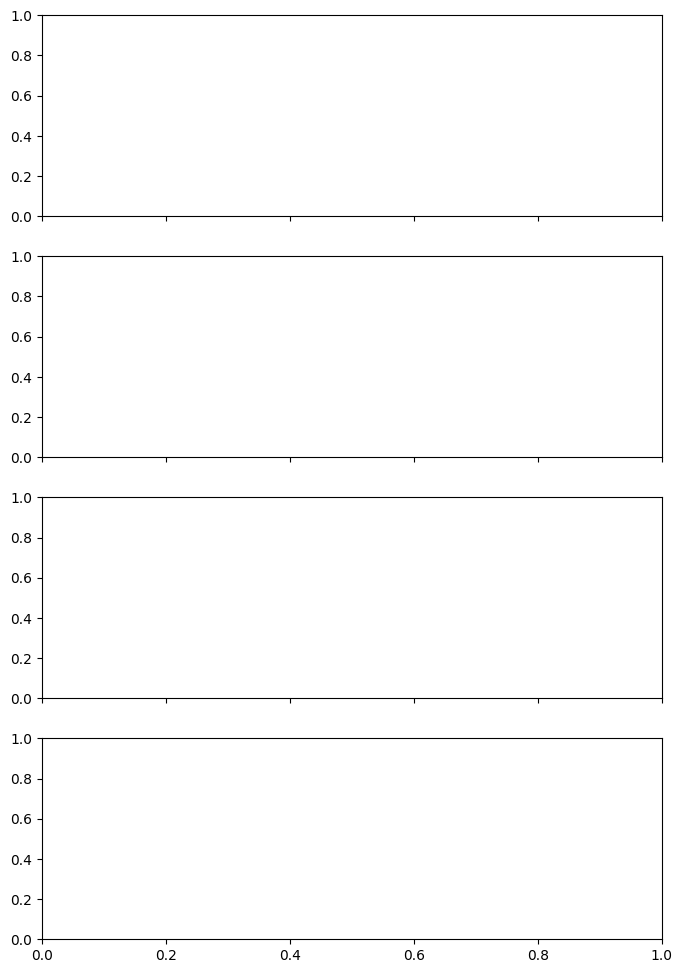

In [15]:
n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Convert start times to MJD and set format
    scheduled_fields[start_col] = Time(scheduled_fields[start_col], format='mjd')
    scheduled_fields[start_col].format = 'iso'
    scheduled_fields[end_col] = scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time for better visualization
    scheduled_fields.sort(end_col)
    
    # Get the start and end times for the vertical lines
    first_start_time = scheduled_fields[start_col].mjd[0]
    last_end_time = scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]  
    # Plot observation time intervals as horizontal lines
    ax.hlines(
        np.arange(len(scheduled_fields)),
        scheduled_fields[start_col].mjd,
        scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(scheduled_fields)):
        ax.vlines(
            scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Plot big vertical lines at the start of the first field and end of the last field
    ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
    ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
    
    # Add labels and title
    ax.set_yticks(np.arange(len(scheduled_fields)))
    ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    ax.legend(loc='upper right')  # Add legend to distinguish vertical lines
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
plt.show()


In [ ]:
scheduled_fields

In [ ]:
# from docplex.mp.model import Model

# # Make sure all time values are in days
# exposure_time_day = exposure_time.to_value(u.day)
# cadence_days = cadence / (24 * 60)  # Convert minutes to days

# # Create and solve the model


# def create_observation_model(prob, observable_fields, exposure_time, cadence_days, slew_time_day, num_visits):
#     m = Model("Telescope Observation Schedule")
    
#     # Index sets
#     n_fields = len(observable_fields)
    
#     # Decision Variables
#     # p[i]: pixel i is inside footprint of selected fields (binary)
#     p = m.binary_var_list(len(prob), name='pixel')
    
#     # r[j]: field j is selected (binary)
#     r = m.binary_var_list(n_fields, name='field')
    
#     # t[j,k]: start time of observation j visit k (continuous)
#     t = [[m.continuous_var(
#         lb=(row['start_time'] - observable_fields['start_time'].min()).to_value(u.day),
#         ub=(row['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day),
#         name=f"start_time_field_{j}_visit_{k}")
#         for k in range(num_visits)] for j, row in enumerate(observable_fields)]
    
#     # Containment Constraints
#     # A pixel is only counted if it's in a selected field
#     for i, fields_containing_pixel in enumerate(footprints_healpix_inverse):
#         m.add_constraint(
#             p[i] <= m.sum(r[j] for j in fields_containing_pixel),
#             ctname=f'containment_{i}'
#         )
    
#     # Cadence Constraints
#     # Minimum time between visits of the same field
#     for j in range(n_fields):
#         for k in range(1, num_visits):
#             m.add_constraint(
#                 t[j][k] - t[j][k-1] >= cadence_days * r[j],
#                 ctname=f'cadence_field_{j}_visit_{k}'
#             )
    
#     # No Overlap Constraints
#     # Observations must be separated by exposure + slew time
#     for j1 in range(n_fields):
#         for j2 in range(j1):
#             for k1 in range(num_visits):
#                 for k2 in range(num_visits):
#                     min_separation = exposure_time_day + slew_time_day[j1][j2]
#                     # Either j1,k1 happens after j2,k2 or vice versa
#                     m.add_constraint(
#                         (t[j1][k1] - t[j2][k2] >= min_separation * (r[j1] + r[j2] - 1)) |
#                         (t[j2][k2] - t[j1][k1] >= min_separation * (r[j1] + r[j2] - 1)),
#                         ctname=f'no_overlap_{j1}_{k1}_{j2}_{k2}'
#                     )
    
#     # Field of Regard Constraints
#     # Start time must be within observable window
#     for j, field in enumerate(observable_fields):
#         for k in range(num_visits):
#             m.add_constraint(
#                 t[j][k] >= (field['start_time'] - observable_fields['start_time'].min()).to_value(u.day) * r[j],
#                 ctname=f'for_start_{j}_{k}'
#             )
#             m.add_constraint(
#                 t[j][k] <= (field['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day) * r[j],
#                 ctname=f'for_end_{j}_{k}'
#             )
    
#     # Objective: Maximize probability coverage
#     objective = m.sum(p[i] * prob[i] for i in range(len(prob)))
#     m.maximize(objective)
    
#     return m

In [ ]:
# model = create_observation_model(prob, observable_fields, exposure_time_day, cadence_days, slew_time_day, num_visits)
# solution = model.solve(log_output=True)